In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import sklearn.preprocessing as prep
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from scipy import interp
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from matplotlib.pyplot import figure
import itertools

from tensorflow.contrib import layers


from sklearn.preprocessing import label_binarize
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

C:\Users\nirav\AppData\Local\Continuum\anaconda3\envs\Tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nirav\AppData\Local\Continuum\anaconda3\envs\Tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nirav\AppData\Local\Continuum\anaconda3\envs\Tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

In [2]:
import os
IMG_SIZE = 48

atm=r'Chokepoint\Youtube Faces\Video\frame_images_DB'
face_cascade = cv2.CascadeClassifier('xml_file/haarcascade_frontalface_default.xml')
directory_list = list()
for root, dirs, files in os.walk(atm, topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))


In [3]:
face_cascade = cv2.CascadeClassifier('xml_file/haarcascade_frontalface_default.xml')

jpg_dir = 'Chokepoint\lfw_jpg'

training_data = []
for img in tqdm(os.listdir(jpg_dir)):
    path = os.path.join(jpg_dir,img)
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for(x,y,w,h) in faces:
        cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
        roi_color = gray[y:y+h, x:x+w]
    
    image = cv2.resize(roi_color, (IMG_SIZE,IMG_SIZE))
    image = image.flatten()
    training_data.append(np.array(image))  
        

100%|██████████| 12751/12751 [01:03<00:00, 199.72it/s]


In [4]:
labels = []
training_data_vid = []
for u in range(50):
    for img in tqdm(os.listdir(directory_list[u])):
        
        path = os.path.join(directory_list[u],img)
        gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for(x,y,w,h) in faces:
            cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
            roi_color = gray[y:y+h, x:x+w]

        image = cv2.resize(roi_color, (IMG_SIZE,IMG_SIZE))
  
        dirname = os.path.split(os.path.split(directory_list[u])[0])[1]

        training_data_vid.append([np.array(image),dirname])  
        labels.append(dirname)

values = array(labels)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

for i in range(len(training_data_vid)):
    training_data_vid[i][1] = np.array(onehot_encoded[i])

    
print(training_data_vid[1])
print(training_data_vid[1][1].shape)

100%|██████████| 71/71 [00:00<00:00, 224.68it/s]


[ 0  0  0 ... 26 26 26]


C:\Users\nirav\AppData\Local\Continuum\anaconda3\envs\Tensorflow2\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['Aaron_Eckhart']
[array([[255, 255, 255, ..., 255, 255, 255],
       [255,  26,  25, ...,   8,  45, 179],
       [255,  22,  22, ...,  11,  62, 182],
       ...,
       [255,  10,   1, ...,  11,  11, 151],
       [255,   7,   2, ...,  11,  11, 151],
       [255, 147, 147, ..., 150, 150, 210]], dtype=uint8), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
(30,)


In [5]:
#Creating and Splitting of Dataset
#train_data = process_images_training()


train = training_data[:-2000]
test = training_data[-2000:]

train_vid = training_data_vid[:-99]
test_vid = training_data_vid[-99:]
train_integer_encoded = integer_encoded[:-99]
test_integer_encoded = integer_encoded[-99:]

print(len(train))
print(len(test))
print(len(train_vid))
print(len(test_vid))

10751
2000
7070
99


In [6]:
#Definitions of layers
initializer = tf.contrib.layers.xavier_initializer()

def weight_variable(shape):
    initial = initializer(shape, dtype=tf.float32)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape=shape, dtype=tf.float32)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,2,2,1], padding='SAME')

def deconv2d(x, W,out):
    return tf.nn.conv2d_transpose(x,W,strides=[1,2,2,1],output_shape = out,padding='SAME' )

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,1,1,1], padding='SAME')

def max_pool_3x3(x):
    return tf.nn.max_pool(x,ksize=[1,3,3,1], strides=[1,1,1,1],padding='SAME')

def conv_layer(input, shape, bias):
    W = shape
    b = bias_variable(bias)
    y = tf.nn.dropout(tf.nn.softplus(conv2d(input, W)+b), dropout)
    return y
def deconv_layer(input, shape, bias,out):
    W = shape
    b = bias_variable(bias)
    return tf.nn.dropout(tf.nn.softplus(deconv2d(input, W,tf.stack(out))+b), dropout)

def full_layer(input, shape, bias):
    W = shape
    b = bias_variable(bias)
    return tf.nn.softplus(tf.add(tf.matmul(input, W),b))


In [7]:
hm_epochs = 2
LearningRate = math.pow(10, -4) * 1
batch_size = 101
dropout=0.95
peopleNum = 30
corruption_level = 0.3

In [8]:
#Dimensions MyData
n1=(int)(2304)
n2=(int)(n1/2)
n3=(int)(n2/2)
n4=(int)(n3/2)
n5=(int)(n4)


weights = {
    'ce0': weight_variable([2,2,1,n1]),
    'ce1': weight_variable([2,2,n1,n2]),
    'ce2': weight_variable([2,2,n2,n3]),
    'ce3': weight_variable([2,2,n3,n4]),
    'ce4': weight_variable([2,2,n4,n5]),
    'cd4': weight_variable([2,2,n4,n5]),
    'cd3': weight_variable([2,2,n3,n4]),
    'cd2': weight_variable([2,2,n2,n3]),
    'cd1': weight_variable([2,2,n1,n2]),
    'cd0': weight_variable([2,2,1,n1]),  
}

weights2= {
    'd0': weight_variable([2*2*288, 2048]),
    'd1': weight_variable([2048, peopleNum]), 
}

print(weights['ce0'])

<tf.Variable 'Variable:0' shape=(2, 2, 1, 2304) dtype=float32_ref>


In [9]:
def encoder(x):
    conv0 = conv_layer(x, weights['ce0'], bias=[n1])
    conv1 = conv_layer(conv0, weights['ce1'], bias=[n2])
    conv2 = conv_layer(conv1, weights['ce2'], bias=[n3])
    conv3 = conv_layer(conv2, weights['ce3'], bias=[n4])
    conv4 = conv_layer(conv3, weights['ce4'], bias=[n5])
    
    return conv4

def autoencoder(x):
    #encoder
    data = tf.reshape(x, shape = [-1,IMG_SIZE,IMG_SIZE,1])
    conv4 = encoder(data)
    
    #decoder
    deconv4 = deconv_layer(conv4, weights['cd4'], bias=[n4],out=[tf.shape(x)[0], 3, 3, n4])
    deconv3 = deconv_layer(deconv4, weights['cd3'], bias=[n3],out=[tf.shape(x)[0], 6,6, n3])
    deconv2 = deconv_layer(deconv3, weights['cd2'], bias=[n2],out=[tf.shape(x)[0], 12, 12, n2])
    deconv1 = deconv_layer(deconv2, weights['cd1'], bias=[n1],out=[tf.shape(x)[0], 24, 24, n1])
    deconv0 = deconv_layer(deconv1, weights['cd0'], bias=[1],out=[tf.shape(x)[0], 48, 48, 1])
    return deconv0

def autoCNN(x):
    data = tf.reshape(x, shape = [-1,48,48,1])
    conv4 = encoder(data)
    
    conv6_flat = tf.reshape(conv4, [-1,2*2*288])
 
    fc_1= full_layer(conv6_flat, weights2['d0'], [2048])
    fc_1 = tf.nn.dropout(fc_1, dropout)
    output = tf.matmul(fc_1, weights2['d1']) + bias_variable([peopleNum])
    print(output)
    return output

In [36]:
#training Phase
def training(x,x_):   
    
    prediction1 = autoencoder(x)
    print(prediction1.shape)

    loss1 = tf.reduce_mean(tf.square(prediction1 - tf.reshape(x, shape=[-1, 48,48,1])))
    optimizer = tf.train.AdamOptimizer(LearningRate)
    optimizer1 = optimizer.minimize(loss1,var_list=[weights])
    loss_list = []
    
    prediction2 = autoCNN(x_)
      
    cost = tf.reduce_mean( tf.losses.softmax_cross_entropy(logits=prediction2, onehot_labels= y_) )
    optimizer2 = optimizer.minimize(cost,var_list=[weights2])
    correct = tf.equal(tf.argmax(prediction2, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))       
    loss_list2 = []
    training_acc_list = []
    test_acc_list = []
    
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        mean_img = np.zeros(2304)
        for epoch in range(hm_epochs):
            epoch_loss = 0
            i = 0
          
            while i < len(train):
                start = i 
                end = i + batch_size
             
                batch_x = np.array(train[start:end])
               
                _, c= sess.run([optimizer1,loss1], feed_dict={x: batch_x})
                epoch_loss += c
                i+= batch_size
               
            loss_list.append(epoch_loss)
            if (epoch+1)%1 == 0:
                print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
        
            #Plotting Results every 5 epochs
                n_examples = 5
                test_xs = np.array(test[:n_examples])
                recon = sess.run(prediction1, feed_dict={x: test_xs})
                fig, axs = plt.subplots(2, n_examples, figsize=(15, 4))
                for example_i in range(n_examples):
                    axs[0][example_i].matshow(np.reshape(test_xs[example_i, :], (48, 48)), cmap=plt.get_cmap('gray'))
                    axs[1][example_i].matshow(np.reshape(np.reshape(recon[example_i, ...], (2304,)) + mean_img, (48, 48)), cmap=plt.get_cmap('gray'))
                    plt.show()
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            i = 0
            while i < len(train_vid):
                start = i 
                end = i + batch_size

                batch_x = np.array(X_data[start:end])
                batch_y = np.array(Y_labels[start:end])

                _, c = sess.run([optimizer2,cost], feed_dict={x_: batch_x, y_: batch_y})
                epoch_loss += c
                i+= batch_size
                print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
                loss_list2.append(epoch_loss)
                if (epoch+1)%1 == 0:
                    training_acc_list.append(training_acc_CNN(sess, accuracy))
                    test_acc_list.append(validation_acc_CNN(sess, accuracy,33))

    predictions = prediction2.eval(feed_dict={x_: cX_data}, session=sess)
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss History")
    plt.show()
    plt.plot(training_acc_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Training Accuracy")
    plt.show()
    plt.plot(test_acc_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Testing Accuracy")
    plt.show()
    roc_auc_graph("Testing",predictions,cY_labels) 
    confusion_matrix_make(sess,predictions,cY_labels)

    precision_recall(sess,predictions,cY_labels)
    perf_measure(cY_labels, predictions)

    live_prediction(sess,prediction2)

    print("Done")  
    print("Done")


In [37]:
x = tf.placeholder(tf.float32, shape=[None,2304])

In [38]:
x_ = tf.placeholder(tf.float32, shape=[None,48,48,1], name='placeholder_input')
y_ = tf.placeholder(tf.float32, shape=[None, peopleNum], name='placeholder_labels') 

y_true_cls = tf.argmax(y_, axis=1)

X_data = np.array([i[0] for i in train_vid]).reshape(-1,48,48,1)
Y_labels = [i[1] for i in train_vid]#.reshape(-1,peopleNum)

print(len(Y_labels))

cX_data = np.array([i[0] for i in test_vid]).reshape(-1,48,48,1)
cY_labels = [i[1] for i in test_vid]#.reshape(-1,peopleNum)

print(len(cX_data))
print(y_)


7070
99
Tensor("placeholder_labels_6:0", shape=(?, 30), dtype=float32)


(?, 48, 48, 1)
Tensor("add_94:0", shape=(?, 30), dtype=float32)
Epoch 1 completed out of 2 loss: 518329.5498046875


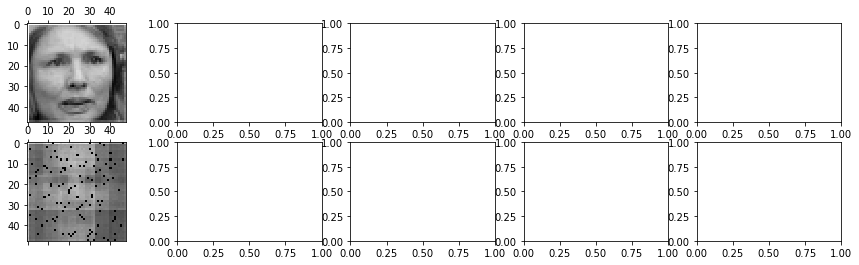

Epoch 2 completed out of 2 loss: 239496.4334716797


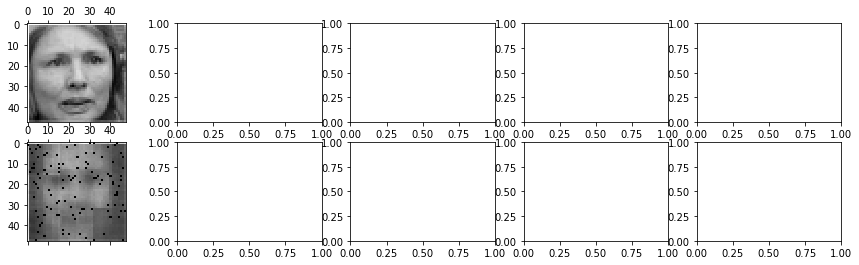

Epoch 1 completed out of 2 loss: 179.50579833984375
Training Accuracy: 2.687411569058895
Validation Accuracy: 0.0
Epoch 1 completed out of 2 loss: 232.25102996826172
Training Accuracy: 2.687411569058895
Validation Accuracy: 0.0
Epoch 1 completed out of 2 loss: 751.3904342651367
Training Accuracy: 2.6449786499142647
Validation Accuracy: 0.0
Epoch 1 completed out of 2 loss: 1131.826042175293
Training Accuracy: 1.867043785750866
Validation Accuracy: 0.0
Epoch 1 completed out of 2 loss: 1620.2080917358398
Training Accuracy: 1.867043785750866
Validation Accuracy: 0.0
Epoch 1 completed out of 2 loss: 1931.6256637573242
Training Accuracy: 3.309759497642517
Validation Accuracy: 0.0
Epoch 1 completed out of 2 loss: 2669.274040222168
Training Accuracy: 3.4512024372816086
Validation Accuracy: 0.0
Epoch 1 completed out of 2 loss: 3163.6399154663086
Training Accuracy: 3.4512024372816086
Validation Accuracy: 0.0
Epoch 1 completed out of 2 loss: 3591.073631286621
Training Accuracy: 3.4512024372816086

KeyboardInterrupt: 

In [35]:
training(x,x_)

In [30]:
def training_acc_CNN(sess, accuracy):     
    training_accuracy_results = []
    cls_pred = np.zeros(shape=len(test_vid), dtype=np.int)
    i = 0
    while i < len(train_vid):
        start = i 
        end = i + batch_size

        batch_x = np.array(X_data[start:end])
        batch_y = np.array(Y_labels[start:end])

        training_accuracy_results.append(sess.run(accuracy, feed_dict={x_: batch_x, y_: batch_y})) 
        i+= batch_size
        
    acc = np.mean(training_accuracy_results)
    print("Training Accuracy: {}".format(acc *100))
    return acc
def validation_acc_CNN(sess, accuracy,batch_size):     
    validation_accuracy_results = []
    cls_pred = np.zeros(shape=len(test_vid), dtype=np.int)
    i = 0
    while i < len(test_vid):
        start = i 
        end = i + batch_size

        batch_x = np.array(cX_data[start:end])
        batch_y = np.array(cY_labels[start:end])

        validation_accuracy_results.append(sess.run(accuracy, feed_dict={x_: batch_x, y_: batch_y})) 
        i+= batch_size
        
    acc = np.mean(validation_accuracy_results)
    print("Validation Accuracy: {}".format(acc*100))
    return acc
    
def roc_auc_graph(typ,predictions,labels):
    test = label_binarize(test_integer_encoded, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
    fpr, tpr, _ = roc_curve(test.ravel(), predictions.ravel())
    roc_auc = auc(fpr, tpr)
    
    print('roc_auc: {}'.format(roc_auc))
    figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Receiver operating characteristic'.format(typ))
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(cm,names, title='Confusion matrix', cmap=plt.cm.Blues,normalize=False):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()


    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def confusion_matrix_make(typ,prediction,labels):
    test = label_binarize(test_integer_encoded, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
    y_test2 = np.argmax(test,axis=1)
    pred = np.argmax(prediction,axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test2, pred, labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    np.set_printoptions(precision=2)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')

    figure(num=None, figsize=(4,4), dpi=80, facecolor='w', edgecolor='k')
    plot_confusion_matrix(cm_normalized, people, title='{} Normalized confusion matrix'.format(typ), normalize = True)

    plt.show()
        
def precision_recall(typ,predictions,labels):
    test = label_binarize(test_integer_encoded, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
    precision, recall, _ = precision_recall_curve(test.ravel(), predictions.ravel())
    
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    
    
    average_precision = average_precision_score(test.ravel(), predictions.ravel())
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision))
    
    figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('{typ} Average precision score, micro-averaged over all classes: AP={average_precision}'
        .format(average_precision=average_precision,typ=typ))
    
def perf_measure(labels, prediction):
    test = label_binarize(test_integer_encoded, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
    y_test2 = np.argmax(test,axis=1)
    pred = np.argmax(prediction,axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test2, pred, labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    print('tp: {}'.format(TP))
    print('fp: {}'.format(FP))
    print('tN: {}'.format(TN))
    print('fn: {}'.format(FN)) 
    
    
def live_prediction(sess,prediction):
    fig=plt.figure()

    for num,data in enumerate(test[:12]):
        img_num = data[1]
        img_data = data[0]

        y = fig.add_subplot(3,4,num+1)
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        
        model_out = prediction.eval(feed_dict={x: [data]}, session=sess)
        if np.argmax(model_out) == 0: str_label='person1'
        elif np.argmax(model_out) == 1: str_label='person3'
        elif np.argmax(model_out) == 2: str_label='person4'
        elif np.argmax(model_out) == 3: str_label='person5'
        elif np.argmax(model_out) == 4: str_label='person6'
        elif np.argmax(model_out) == 5: str_label='person7'
        elif np.argmax(model_out) == 6: str_label='person9'
        elif np.argmax(model_out) == 7: str_label='person10'
        elif np.argmax(model_out) == 8: str_label='person11'
        elif np.argmax(model_out) == 9: str_label='person12'
        elif np.argmax(model_out) == 10: str_label='person13'
        elif np.argmax(model_out) == 11: str_label='person14'
        elif np.argmax(model_out) == 12: str_label='person15'
        elif np.argmax(model_out) == 13: str_label='person16'
        elif np.argmax(model_out) == 14: str_label='person17'
        elif np.argmax(model_out) == 15: str_label='person18'
        elif np.argmax(model_out) == 16: str_label='person19'
        elif np.argmax(model_out) == 17: str_label='person20'
        elif np.argmax(model_out) == 18: str_label='person21'
        elif np.argmax(model_out) == 19: str_label='person22'
        else: str_label='unknown'

        y.imshow(orig,cmap='gray')
        plt.title(str_label)
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)
    plt.show()
            
        

def image_labeler_converter(labelName):
    if np.array_equal(labelName,[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]): return 0
    elif np.array_equal(labelName,[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]): return 1
    elif np.array_equal(labelName,[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]): return 2
    elif np.array_equal(labelName,[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]): return 3
    elif np.array_equal(labelName,[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]): return 4
    elif np.array_equal(labelName,[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]): return 5
    elif np.array_equal(labelName,[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]): return 6
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]): return 7
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]): return 8
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]): return 9
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]): return 10
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]): return 11
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]): return 12
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]): return 13
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]): return 14
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]): return 15
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]): return 16
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]): return 17
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]): return 18
    elif np.array_equal(labelName,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]): return 19
    else: return 20        

In [ ]:
def training_CNN(data):   
    prediction = autoCNN(data)
    print(prediction.shape)
    print(y_.shape)
    tf.identity(prediction, name="Output_ph")
    cost = tf.reduce_mean( tf.losses.softmax_cross_entropy(logits=prediction, onehot_labels= y_) )
    optimizer = tf.train.AdamOptimizer(LearningRate).minimize(cost)
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))       
    loss_list = []
    training_acc_list = []
    test_acc_list = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(hm_epochs):
            epoch_loss = 0
            i = 0
            while i < len(train_vid):
                start = i 
                end = i + batch_size

                batch_x = np.array(X_data[start:end])
                batch_y = np.array(Y_labels[start:end])
                
                _, c = sess.run([optimizer,cost], feed_dict={x_: batch_x, y_: batch_y})
                epoch_loss += c
                i+= batch_size
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
            loss_list.append(epoch_loss)
            if (epoch+1)%1 == 0:
                training_acc_list.append(training_acc_CNN(sess, accuracy))
                test_acc_list.append(validation_acc_CNN(sess, accuracy,33))

        predictions = prediction.eval(feed_dict={x_: cX_data}, session=sess)
        
        print(prediction)
        print(predictions)
        
        plt.plot(loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Loss History")
        plt.show()
        plt.plot(training_acc_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Training Accuracy")
        plt.show()
        plt.plot(test_acc_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Testing Accuracy")
        plt.show()
        roc_auc_graph("Testing",predictions,cY_labels) 
        confusion_matrix_make(sess,predictions,cY_labels)

        precision_recall(sess,predictions,cY_labels)
        perf_measure(cY_labels, predictions)
        
        live_prediction(sess,prediction)
        
        print('\nSaving...')
        inputs_dict = {
            "features_data_ph": x,
            "labels_data_ph": y_
        }
        outputs_dict = {
            "Output_ph": prediction
        }
        #tf.saved_model.simple_save(sess, file_path, inputs_dict, outputs_dict)
        print("Done")

In [ ]:
training_CNN(x_)